Saving CAR DETAILS FROM CAR DEKHO.csv to CAR DETAILS FROM CAR DEKHO.csv
Dataset Preview:
                       name  year  selling_price  km_driven    fuel  \
0             Maruti 800 AC  2007          60000      70000  Petrol   
1  Maruti Wagon R LXI Minor  2007         135000      50000  Petrol   
2      Hyundai Verna 1.6 SX  2012         600000     100000  Diesel   
3    Datsun RediGO T Option  2017         250000      46000  Petrol   
4     Honda Amaze VX i-DTEC  2014         450000     141000  Diesel   

  seller_type transmission         owner  
0  Individual       Manual   First Owner  
1  Individual       Manual   First Owner  
2  Individual       Manual   First Owner  
3  Individual       Manual   First Owner  
4  Individual       Manual  Second Owner  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name          

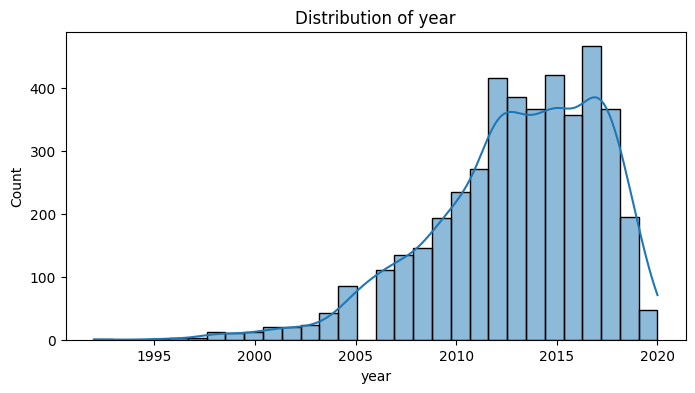

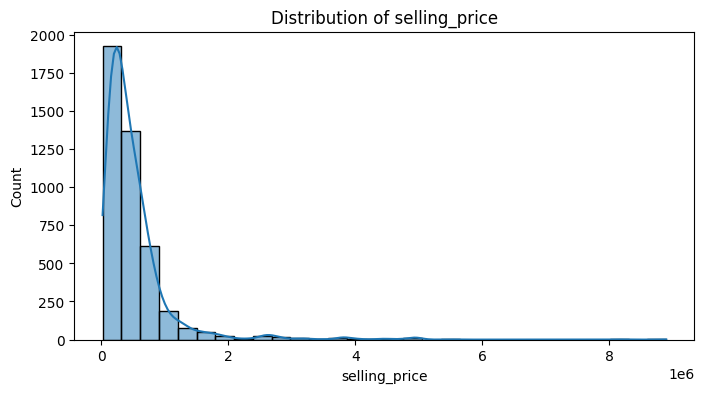

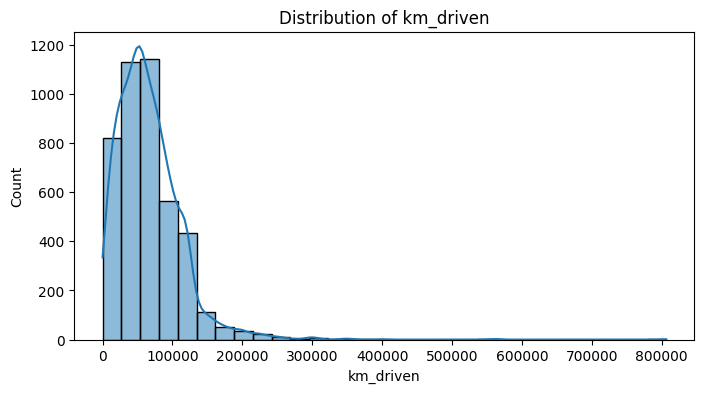

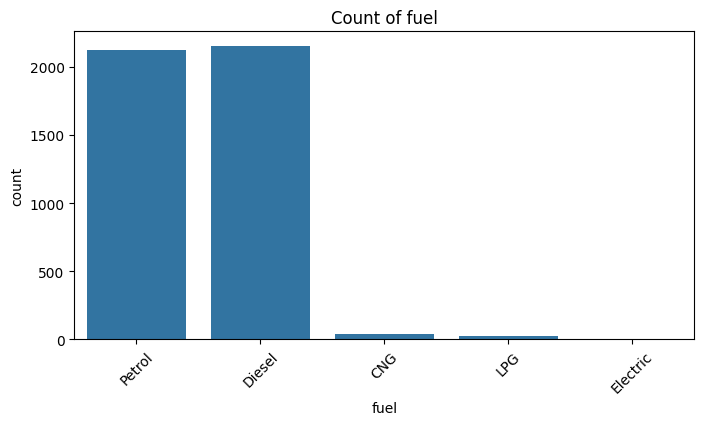

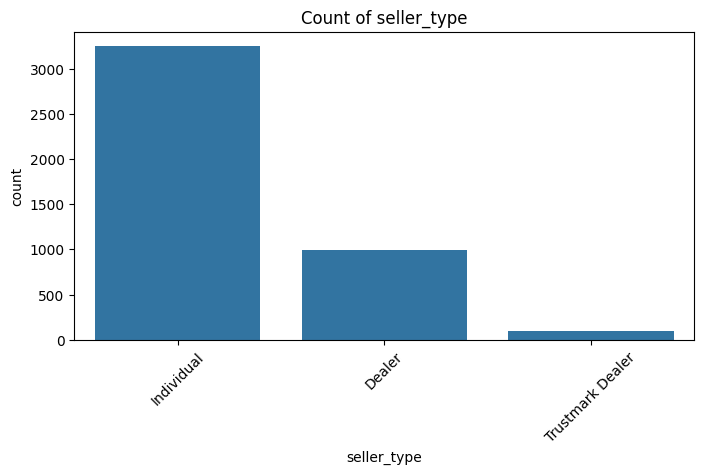

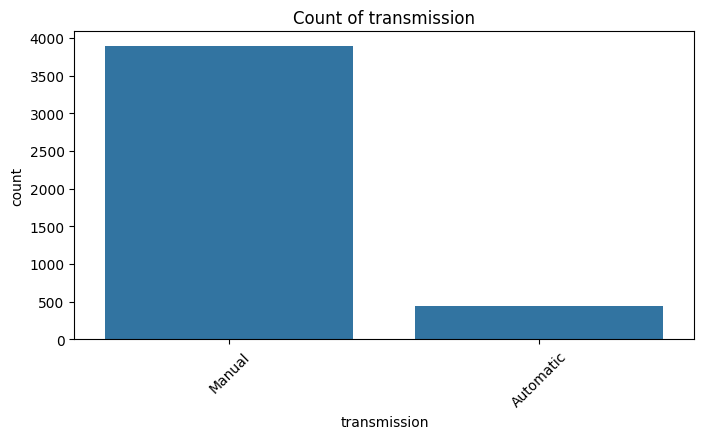

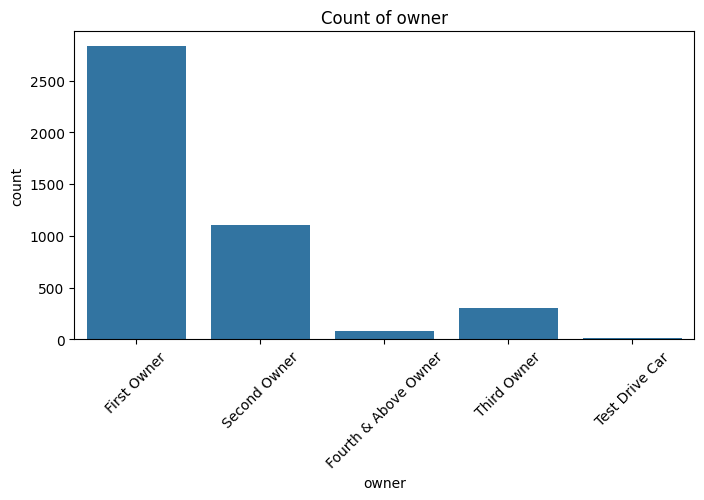

In [ ]:
# Install required libraries (if not already installed)
!pip install pandas matplotlib seaborn scikit-learn -q

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Use file upload function
from google.colab import files
uploaded = files.upload()

# Load the dataset
car_data = pd.read_csv("CAR DETAILS FROM CAR DEKHO.csv")

# Display first few rows of the dataset
print("Dataset Preview:")
print(car_data.head())

# Step 1: Data Exploration
print("\nDataset Info:")
print(car_data.info())

print("\nSummary Statistics:")
print(car_data.describe())

# Check for missing values
print("\nMissing Values:")
print(car_data.isnull().sum())

# Distribution of numerical features
num_cols = ['year', 'selling_price', 'km_driven']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(car_data[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# Categorical feature analysis
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=car_data, x=col)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()

# Step 2: Feature Engineering
# Encoding categorical variables
car_data_encoded = pd.get_dummies(car_data, columns=cat_cols, drop_first=True)

# Drop unnecessary columns
car_data_encoded = car_data_encoded.drop(columns=['name'])

# Feature-target split
X = car_data_encoded.drop(columns=['selling_price'])
y = car_data_encoded['selling_price']






In [ ]:
# Step 3: Model Selection and Training
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Step 4: Model Evaluation
# Predict on the test set
y_pred = rf_model.predict(X_test)


Model Performance:
Mean Absolute Error (MAE): 168994.44108928187
Root Mean Squared Error (RMSE): 392030.0028125828
Cross-Validation RMSE: 337062.7209025612 ± 71231.84478358866


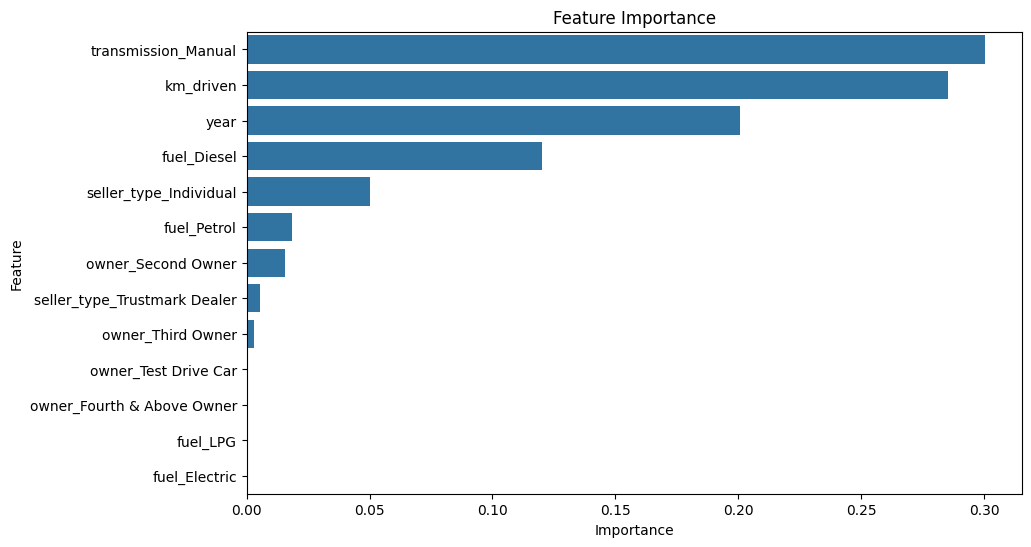

In [ ]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Cross-validation for robustness
cv_scores = cross_val_score(rf_model, X, y, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE: {cv_rmse.mean()} ± {cv_rmse.std()}")

# Feature importance visualization
importances = rf_model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title("Feature Importance")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


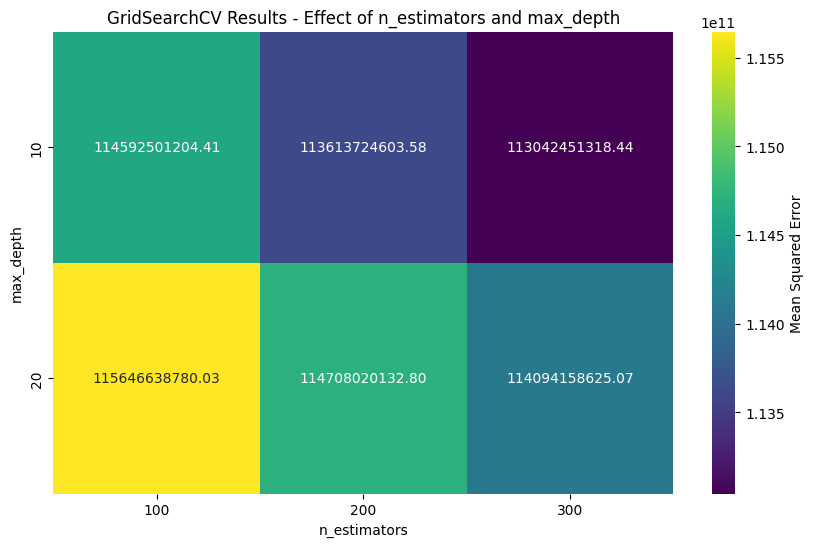

<ipython-input-6-66c2d660d067>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


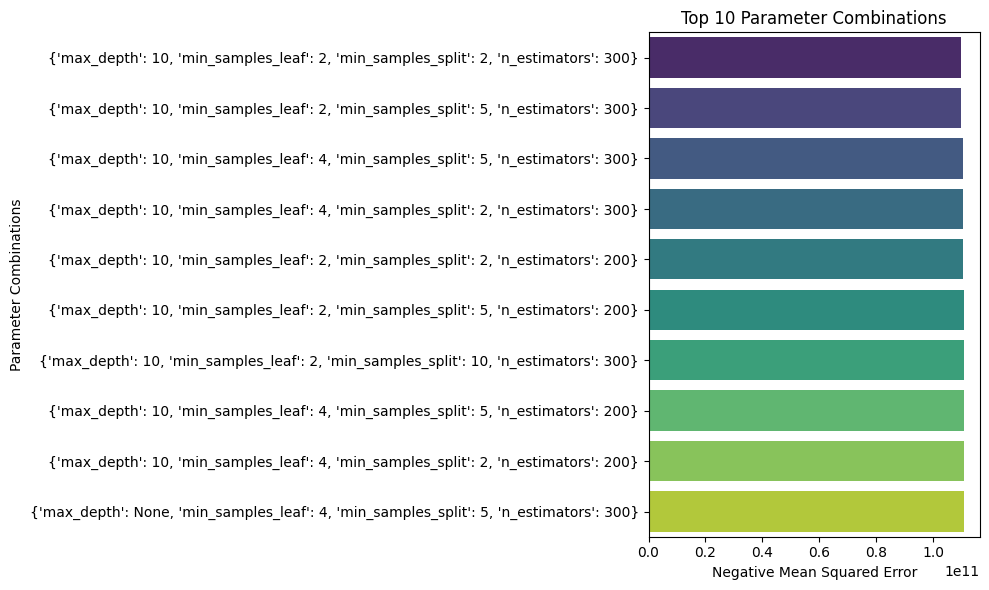

In [ ]:
# Extract results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Pivot the results to analyze the effect of 'n_estimators' and 'max_depth'
pivot = results.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

# Plot a heatmap for 'n_estimators' and 'max_depth'
plt.figure(figsize=(10, 6))
sns.heatmap(-pivot, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Mean Squared Error'})
plt.title("GridSearchCV Results - Effect of n_estimators and max_depth")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

# Plot the top combinations of parameters and their scores
top_results = results.sort_values(by='mean_test_score', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=-top_results['mean_test_score'],
    y=top_results['params'].astype(str),
    palette="viridis"
)
plt.title("Top 10 Parameter Combinations")
plt.xlabel("Negative Mean Squared Error")
plt.ylabel("Parameter Combinations")
plt.tight_layout()
plt.show()
